<a href="https://colab.research.google.com/github/alarabalaman6/Mobility-Data-Analysis/blob/main/Car_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from geopy.distance import geodesic
from datetime import datetime

In [3]:
cars_df = pd.read_csv('/content/Car.csv')
travels_df = pd.read_csv('/content/Travel.csv')
users_df = pd.read_csv('/content/Users.csv')

In [4]:
# Select Relevant Features
car_selected = cars_df[['carLicensePlate', 'brand', 'model', 'colour', 'year']]

travel_selected = travels_df[['carLicensePlate', 'users', 'offerId', 'startPlace.latitude',
                             'startPlace.longitude', 'endPlace.latitude', 'endPlace.longitude',
                             'startDate', 'endDate',]]
users_selected = users_df[['id', 'balance', 'reputation']]


In [24]:
# Merge Datasets
# Merge Car with Travel
merged_df = pd.merge(travel_selected, car_selected, how= 'left', on= 'carLicensePlate' )


# Extracting main user from the 'users' column
def extract_main_user(x):
  user_list = eval(x)
  if user_list:
    return user_list[0]['userId']
  else: return None

merged_df['main_user'] = merged_df['users'].apply(extract_main_user)

# Merge with Users to get user details
merged_df = pd.merge(merged_df, users_selected, how= 'left', left_on= 'main_user', right_on= 'id').drop(columns = ['id'])


merged_df.head()


,carLicensePlate,users,offerId,startPlace.latitude,startPlace.longitude,endPlace.latitude,endPlace.longitude,startDate,endDate,brand,model,colour,year,main_user,balance,reputation
0,3D7JB1EPXBG126865,"[{""userId"":""Alberta"",""passengers"":2},{""userId""...",bbf22efb-66a6-4569-8a4f-6602b75abed5,-22.845810,-47.228885,49.838180,20.978904,1571595235,1571642035,Volkswagen,GTI,Mauv,1993,Alberta,89.15,7.5
1,SAJWA0ES5EP943471,"[{""userId"":""Randolph"",""passengers"":1},{""userId...",a29ac556-7fe7-4b70-b9e7-0236674c0168,57.146670,33.107530,38.600000,-121.450000,1563529740,1563580140,Mercedes-Benz,GL-Class,Yellow,2012,Randolph,90.09,7.7
2,JH4CW2H5XCC717031,"[{""userId"":""Isaak"",""passengers"":2},{""userId"":""...",913395a2-c388-41e0-9cda-0ac12d2bb6b3,2.504560,73.308231,14.895168,-24.494564,1545874286,1545949886,Nissan,Pathfinder,Teal,2011,Isaak,33.37,1.3
3,1N4AA5AP8AC567587,"[{""userId"":""Annabelle"",""passengers"":1}]",4bd92710-8bde-4cc8-b8c5-907411d4117b,38.399170,125.615560,-8.109499,115.161894,1563601351,1563680551,Jeep,Wrangler,Aquamarine,2003,Annabelle,78.48,6.8
4,WAUSF98E97A783106,"[{""userId"":""Kissie"",""passengers"":1}]",3543231d-761f-4191-bf58-3219b28d7c15,53.985881,16.981176,14.570330,121.147400,1572920574,1572931374,Chevrolet,G-Series G30,Orange,1996,Kissie,27.48,3.5


In [ ]:
# Information about the dataset
dataset_info = merged_df.info()

# Summary statistics for numerical features
numerical_summary = merged_df.describe()

# Check for missing values
missing_values = merged_df.isnull().sum()

dataset_info, numerical_summary, missing_values


I saw here that all the timestamps for startDate and endDate in my data are the same meaning there is going to be many zero durations even though they have nonzero distances. So I will adjust them based on the distance traveled and the duration of similar travels.

In [11]:
   # Calculate distance for each travel
def calculate_distance(row):
      start_coords = (row['startPlace.latitude'], row['startPlace.longitude'])
      end_coords = (row['endPlace.latitude'], row['endPlace.longitude'])
      return geodesic(start_coords, end_coords).miles

merged_df['distance'] = merged_df.apply(calculate_distance, axis=1)

In [34]:
# Convert date columns to readable format
for col in ['startDate', 'endDate']:
    merged_df[col] = pd.to_datetime(merged_df[col], unit='s')


# Calculate the duration of each travel in hours
merged_df['travel_duration'] = (merged_df['endDate'] - merged_df['startDate']).dt.total_seconds() / 3600


In [13]:
# Checking for zero duration rows with non-zero distance
zero_duration_rows = merged_df[(merged_df['travel_duration'] == 0) & (merged_df['distance'] > 0)]
print(zero_duration_rows)


       carLicensePlate                                              users  \
10   WAULD54BX2N317605  [{"userId":"Jeramey","passengers":2},{"userId"...   
19   3C63DRML0CG647872  [{"userId":"Isidoro","passengers":2},{"userId"...   
27   WAUHE78P59A429685  [{"userId":"Everard","passengers":1},{"userId"...   
50   JH4CU2E82EC411285  [{"userId":"Darrelle","passengers":1},{"userId...   
70   KNADM4A33C6722809  [{"userId":"Armstrong","passengers":1},{"userI...   
87   1G6DU6EA0A0470673            [{"userId":"Antonella","passengers":1}]   
110  WAUGGAFR5EA987439           [{"userId":"Bernadette","passengers":2}]   
159  WAUPL58E05A150790  [{"userId":"Arny","passengers":1},{"userId":"H...   
227  5GAKRAEDXCJ545476  [{"userId":"Bunny","passengers":1},{"userId":"...   
253  WVGDF9BP6ED447569                 [{"userId":"Dory","passengers":2}]   
301  3VW1K7AJ3DM027790  [{"userId":"Marijn","passengers":1},{"userId":...   
302  3VW1K7AJ3DM027790  [{"userId":"Marijn","passengers":1},{"userId":...   

In [16]:
#Find similar travel records
tolerance = 5  # Defining a tolerance limit for distance
similar_travel_records = merged_df[(abs(merged_df['distance'] - zero_duration_rows.iloc[0]['distance']) <= tolerance)]


#Calculate a new 'endDate' for identical start and end timestamp rows
mean_duration = similar_travel_records['travel_duration'].mean()
zero_duration_rows['endDate'] = zero_duration_rows['startDate'] + pd.to_timedelta(mean_duration, unit='h')
merged_df.loc[zero_duration_rows.index, 'endDate'] = zero_duration_rows['endDate']


<ipython-input-16-d800b6eb814c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_duration_rows['endDate'] = zero_duration_rows['startDate'] + pd.to_timedelta(mean_duration, unit='h')


In [ ]:
# Statistical analysis for the selected attributes

# 1. Car Brand Distribution
car_brand_stats = cars_df['brand'].value_counts()

# 2. Car Colour Variety
car_colour_stats = cars_df['colour'].value_counts()

# 3. Car Year Summary
car_year_stats = cars_df['year'].describe()

# 4. User Reputation Scores
user_reputation_stats = users_df['reputation'].describe()

# 5. User Balance Summary
user_balance_stats = users_df['balance'].describe()

# Compile the statistical summaries into a dictionary
stats_summaries = {
    'Car Brand Distribution': car_brand_stats,
    'Car Colour Variety': car_colour_stats,
    'Car Year Distribution': car_year_stats,
    'User Reputation Scores': user_reputation_stats,
    'User Balance Summary': user_balance_stats
}

# Display the statistical summaries
stats_summaries


In [ ]:
# Visualizations
sns.set(style="whitegrid")

# Visualization for Car Brand Distribution
plt.figure(figsize=(14, 7))
car_brand_stats.plot(kind='bar')
plt.title('Car Brand Distribution')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Visualization for the distribution of car-usage by car's year
plt.figure(figsize=(12, 6))
sns.histplot(data=merged_df, x='year', bins=30)
plt.title('Distribution of Car Usage by Year')
plt.xlabel('Manufacturing Year')
plt.ylabel('Times of Usage')
plt.legend(title='Car Usage')
plt.show()

# Visualization for Car Color Variety
plt.figure(figsize=(14, 7))
car_colour_stats.plot(kind='bar', color=sns.color_palette("hls", 20))
plt.title('Car Color Variety')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


# Visualization for User Reputation Scores
plt.figure(figsize=(14, 7))
sns.boxplot(x=users_df['reputation'])
plt.title('User Reputation Scores')
plt.xlabel('Reputation Score')
plt.show()

# Visualization for User Balance Distribution
plt.figure(figsize=(14, 7))
sns.histplot(users_df['balance'], bins=30, kde=False, color='green')
plt.title('User Balance Distribution')
plt.xlabel('Balance ($)')
plt.ylabel('Count')
plt.show()

# Visualization for the distribution of travel_duration
plt.figure(figsize=(12, 6))
chart = sns.histplot(merged_df['travel_duration'], bins=50, kde=True, color='skyblue', alpha=1.0)
plt.title('Distribution of Travel Duration')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Count')
plt.show()

In [40]:
merged_df.info()
merged_numeric_df = merged_df.select_dtypes(include=['number']).drop(columns=['year'])
corr_matrix = merged_numeric_df.corr()
corr_matrix

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   carLicensePlate       361 non-null    object        
 1   users                 361 non-null    object        
 2   offerId               361 non-null    object        
 3   startPlace.latitude   361 non-null    float64       
 4   startPlace.longitude  361 non-null    float64       
 5   endPlace.latitude     361 non-null    float64       
 6   endPlace.longitude    361 non-null    float64       
 7   startDate             361 non-null    datetime64[ns]
 8   endDate               361 non-null    datetime64[ns]
 9   brand                 361 non-null    object        
 10  model                 361 non-null    object        
 11  colour                361 non-null    object        
 12  year                  361 non-null    int64         
 13  main_user           

,startPlace.latitude,startPlace.longitude,endPlace.latitude,endPlace.longitude,balance,reputation,travel_duration
startPlace.latitude,1.000000,0.049375,0.096199,0.040778,-0.036951,0.003936,-0.057554
startPlace.longitude,0.049375,1.000000,-0.043887,0.025114,0.121986,-0.050608,0.091657
endPlace.latitude,0.096199,-0.043887,1.000000,0.015398,0.049470,0.038914,0.021648
endPlace.longitude,0.040778,0.025114,0.015398,1.000000,-0.055261,-0.131022,0.020099
balance,-0.036951,0.121986,0.049470,-0.055261,1.000000,-0.064752,-0.037010
reputation,0.003936,-0.050608,0.038914,-0.131022,-0.064752,1.000000,0.018217
travel_duration,-0.057554,0.091657,0.021648,0.020099,-0.037010,0.018217,1.000000


Because my data is synthesized and fake, I couldn't find any meaningful relationships. So I will create an artificial relationship between user balance and the type of car they use. Users with higher balances might prefer newer car models.

In [42]:
merged_df['year'].describe()

count     361.000000
mean     2000.005540
std        10.108026
min      1953.000000
25%      1994.000000
50%      2002.000000
75%      2007.000000
max      2013.000000
Name: year, dtype: float64

In [44]:
# Assigning recent manufacturing years for high balances and random years for low balances
def calculate_preferred_year(balance):
    if balance > 50:
        return np.random.randint(2008, 2014)
    else:
        return np.random.choice(merged_df['year'])

# Apply the custom function to create the 'preferred_year' column
merged_df['preferred_year'] = merged_df['balance'].apply(calculate_preferred_year)

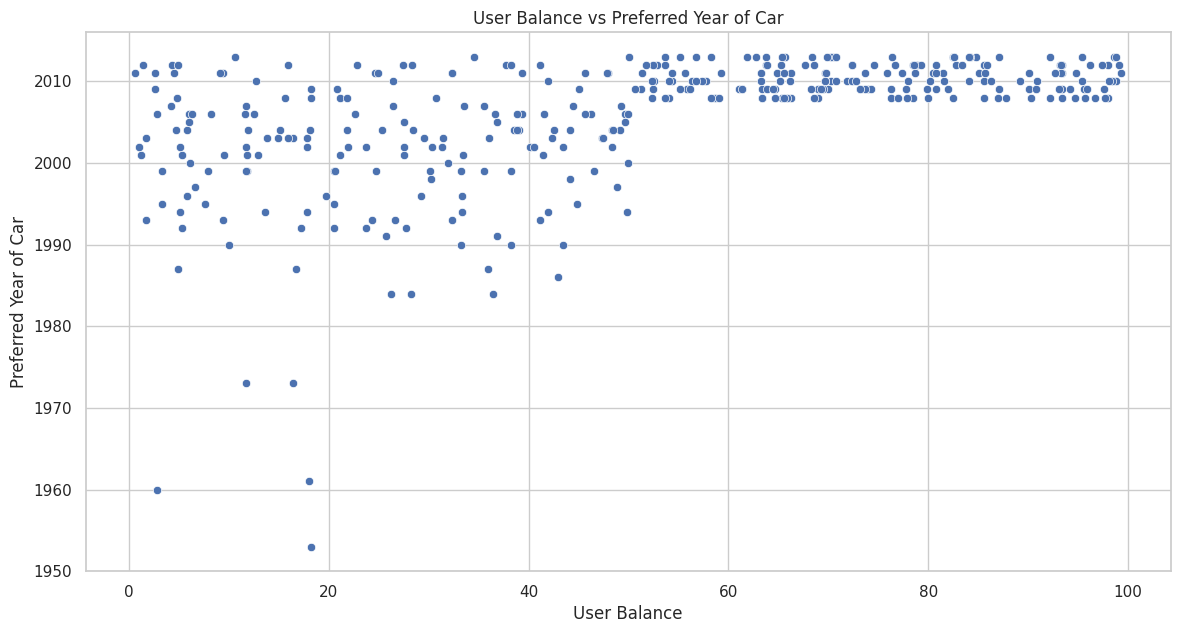

In [45]:
# Create a scatter plot for the balance vs preferred year of car for users
plt.figure(figsize=(14, 7))
sns.scatterplot(x='balance', y='preferred_year', data=merged_df)
plt.title('User Balance vs Preferred Year of Car')
plt.xlabel('User Balance')
plt.ylabel('Preferred Year of Car')
plt.show()

In [46]:
def geospatial_analysis(filepath):

    # Load the dataset into a Geo Dataframe
    gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df['startPlace.longitude'], merged_df['startPlace.latitude']))

    # Remove rows with missing or erroneous geospatial data
    gdf = gdf[gdf['geometry'].is_valid]

    # Create a base map with the location means
    m = folium.Map(location=[gdf['startPlace.latitude'].mean(), gdf['startPlace.longitude'].mean()], zoom_start=2)

    # Add heatmap to the map
    heat_data = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry]
    HeatMap(heat_data).add_to(m)

    # Add clustering to the map
    marker_cluster = MarkerCluster().add_to(m)
    for idx, row in gdf.iterrows():

        # Create a popup content for car info
        popup_content = f"Car Brand: {row['brand']}<br>Car Model: {row['model']}<br>Car Year: {row['year']}"
        popup = folium.Popup(popup_content, max_width=450)

        folium.Marker(
            [row['startPlace.latitude'], row['startPlace.longitude']],
            popup=popup
        ).add_to(marker_cluster)


     # Save the map
    m.save('geospatial_analysis.html')

    return m

geospatial_analysis('<PATH_TO_Travel.csv>')




